https://github.com/higgsfield/RL-Adventure/blob/master/1.dqn.ipynb

In [1]:
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F
from IPython.core.debugger import set_trace

In [2]:
torch.__version__

'1.0.1.post2'

In [3]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() \
    if USE_CUDA else autograd.Variable(*args, **kwargs)

In [4]:
env = gym.make('CartPole-v0')

In [5]:
obs = env.reset()

In [6]:
obs   # cart pos, vel, pole angle, vel

array([ 0.00630608, -0.00430494,  0.04223876,  0.02187019])

In [7]:
env.step(0)

(array([ 0.00621998, -0.20000639,  0.04267617,  0.32757503]), 1.0, False, {})

In [8]:
class DumbModel():
    def __init__(self):
        pass
    def act(self, state):
        return 0 if state[2] < 0 else 1
    
p = DumbModel()

In [42]:
class ReplayBuffer():
    def __init__(self, capacity, to_torch=False):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)
        self.to_torch = to_torch
        
    def store(self, state, action, rewards, next_state, done):
        self.buffer.append([state, action, rewards, next_state, done])
        
    def batch(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        state, next_state = np.stack(state), np.stack(next_state)
        if self.to_torch:
            return (
                torch.FloatTensor(state), 
                torch.LongTensor(action), 
                torch.FloatTensor(reward), 
                torch.FloatTensor(next_state), 
                torch.FloatTensor(done)
            )
        else:
            return state, action, reward, next_state, np.array(done, dtype='int')
    
    def reset(self):
        self.buffer = deque(maxlen=self.capacity)
        
    def __len__(self):
        return len(self.buffer)

In [55]:
class ReinforcementAlgorithm():
    def __init__(self, env, model, optimizer, num_steps, capacity, batch_size, gamma, eps,
                 loss=F.mse_loss):
        self.env = env
        self.model = model
        self.optimizer = optimizer
        self.replay_buffer = ReplayBuffer(capacity)
        self.num_steps = num_steps
        self.batch_size = batch_size
        self.gamma = gamma
        self.eps = eps
        self.loss = loss
        self.step_counter = 0
        self.rewards, self.losses, self.qs = [], [], []
        
    def iterate(self, num_episodes):
        for e in range(num_episodes):
            self.episode()
    
    def episode(self):
        state = self.env.reset()
        episode_rewards = 0
        for t in range(self.num_steps):
            action = self.model.act(state, self.eps(self.step_counter))
            
            next_state, reward, done, _ = self.env.step(action)
            self.replay_buffer.store(state, action, reward, next_state, done)
            
            state = next_state
            self.step_counter += 1
            episode_rewards += reward
            
            if done:
                #self.replay_buffer.reset()
                self.rewards.append(episode_rewards)
                break
                
            if len(self.replay_buffer) > self.batch_size:
                loss = self.compute_loss()
#                 self.optimize_model(loss)
#                 self.losses.append(loss.detach().numpy())
    
    def compute_loss(self, debug=False):
        state, action, reward, next_state, done = self.replay_buffer.batch(self.batch_size)

#         q_choice = self.model(state).gather(1, action.unsqueeze(1))
        
#         with torch.no_grad():
#             q_next = self.model(next_state).max(1)[0]
#             y = reward + self.gamma * q_next * (1 - done)
#             y = torch.FloatTensor(y.detach().numpy())
        
#         if debug: set_trace()
#         loss = self.loss(y, q_choice)
#         self.qs.append(q_choice.mean().item())
        q_next = self.model.model.predict_on_batch(next_state).max(1)
        self.qs.append(q_next.mean())
        y = reward + self.gamma * q_next * (1 - done)
        loss =  self.model.model.train_on_batch(state, y)
        self.losses.append(loss)
        #return loss
    
    def optimize_model(self, loss):
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
            

In [27]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state = torch.FloatTensor(state).unsqueeze(0)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].numpy()[0]
        else:
            action = random.randrange(env.action_space.n)
        return action

In [28]:
import tensorflow.keras as keras
from tensorflow.keras.layers import *

In [37]:
class DQN_Keras():
    def __init__(self, num_inputs, num_actions):
        
        self.model = keras.models.Sequential([
            Dense(128, input_shape=(num_inputs,), activation='relu'),
            Dense(128, activation='relu'),
            Dense(num_actions)
        ])
        
        self.model.compile(keras.optimizers.Adam(0.001), 'mse')
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            q_value = self.model.predict_on_batch(state[None])[0]
            action  = q_value.argmax()
        else:
            action = random.randrange(env.action_space.n)
        return action

In [56]:
dqn_keras = DQN_Keras(4, 2)

In [57]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [58]:
dqn = DQN(4, 2)

In [59]:
opt = optim.Adam(dqn.parameters())

In [60]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

eps = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * np.exp(-1. * frame_idx / epsilon_decay)

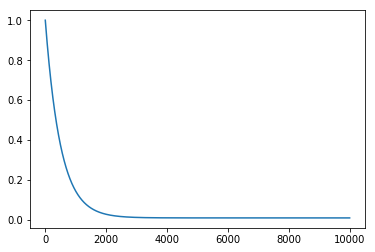

In [61]:
plt.plot([eps(i) for i in range(10000)])

In [62]:
ra = ReinforcementAlgorithm(
    env=env, 
    model=dqn_keras, 
    optimizer=None,
    num_steps=200, 
    capacity=1000, 
    batch_size=32, 
    gamma=0.99,
    eps=eps,
    loss=F.mse_loss
)

In [71]:
ra.iterate(500)

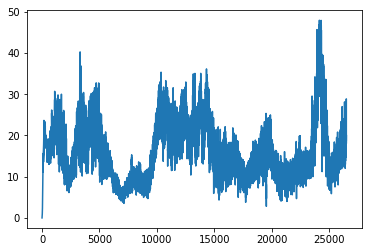

In [72]:
plt.plot(ra.qs)

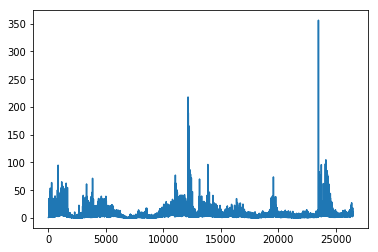

In [73]:
plt.plot(ra.losses)

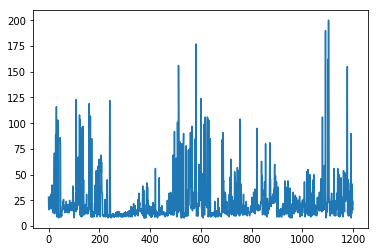

In [74]:
plt.plot(ra.rewards)

In [213]:
ra.compute_loss(True)

> <ipython-input-184-10a313200f92>(53)compute_loss()
     51 
     52         if debug: set_trace()
---> 53         loss = self.loss(y, q_choice)
     54         return loss
     55 

ipdb> q_choice
tensor([[10.8885],
        [10.5494],
        [10.5111],
        [10.8270],
        [11.0753],
        [10.6527],
        [10.5557],
        [10.6284],
        [10.9709],
        [10.9842],
        [10.7421],
        [10.6810],
        [10.8541],
        [10.5620],
        [10.6097],
        [10.8314],
        [10.5143],
        [11.0551],
        [10.8045],
        [10.9633],
        [10.9322],
        [10.9653],
        [10.8163],
        [10.5691],
        [10.7612],
        [10.7491],
        [10.5576],
        [10.8799],
        [10.7484],
        [10.5507],
        [10.5000],
        [10.7911]], grad_fn=<GatherBackward>)
ipdb> q


BdbQuit: 

In [366]:
len(ra.replay_buffer)

1000

In [76]:
ra.replay_buffer.buffer[0][3].requires_grad()

AttributeError: 'numpy.ndarray' object has no attribute 'requires_grad'

In [77]:
state, action, reward, next_state, done = ra.replay_buffer.batch(2)

In [79]:
next_state.requires_grad

False

In [445]:
ra.model(state)

tensor([[ 0.2014, -0.1713],
        [ 0.1107, -0.1490]], grad_fn=<AddmmBackward>)

In [189]:
state, action, reward, next_state, done = ra.replay_buffer.batch(2)

In [190]:
ra.model = dqn

In [191]:
ra.compute_loss()

tensor(1.0911, grad_fn=<MeanBackward1>)

In [241]:
state=env.reset()

In [249]:
dqn.act(state, 0)

> <ipython-input-243-58569c1d7f77>(24)act()
     20             action  = q_value.max(1)[1].numpy()
     21             set_trace()
     22         else:
     23             action = random.randrange(env.action_space.n)
---> 24         return action

ipdb> action
array([0])
ipdb> action[0]
0
ipdb> action.squeeze()
array(0)
ipdb> q


BdbQuit: 

In [154]:
%debug

> <ipython-input-144-6b598f460d84>(1)<module>()
----> 1 a.gather(1)

ipdb> q


In [231]:
q = dqn(state); q

AttributeError: 'numpy.ndarray' object has no attribute 'dim'

In [164]:
q.gather(1, a.unsqueeze(1))

tensor([[-0.1285],
        [-0.0456]], grad_fn=<GatherBackward>)

In [157]:
a = dqn.act(state, epsilon=0); a

tensor([0, 1])

In [159]:
a.unsqueeze(1)

tensor([[0],
        [1]])

# Old

In [42]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.distributions import Categorical

In [161]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        
        self.l1 = nn.Linear(4, 128)
        self.l2 = nn.Linear(128, 2)
        self.reward_episode = []
        self.policy_history = Variable(torch.Tensor())
    
    def forward(self, x):
        model = nn.Sequential(
            self.l1,
            nn.ReLU(),
            self.l2,
            nn.Softmax(dim=-1)
        )
        return model(x)

In [162]:
policy = Policy()
optimizer = torch.optim.Adam(policy.parameters(), lr=0.01)

In [159]:
def select_action(state):
    state = Variable(torch.from_numpy(state).type(torch.FloatTensor))
    probs = policy(state)
    c = Categorical(probs)
    action = c.sample()
    
    # Add log probability of our chosen action to our history    
    if policy.policy_history.dim() != 0:
        policy.policy_history = torch.cat([policy.policy_history, c.log_prob(action)])
    else:
        policy.policy_history = (c.log_prob(action))
    return action

In [160]:
action = select_action(obs); action

Variable containing:
 1
[torch.LongTensor of size 1]

In [99]:
env.step(action.data[0])

(array([-1344.03450664,  -155.81419121,  -170.77739134,   -12.29331747]),
 0.0,
 True,
 {})

In [211]:
from IPython.core import debugger as pdb

In [212]:
def update_policy():
    R = 0
    gamma = 0.95
    rewards = []
    for r in policy.reward_episode[::-1]:
        R = r + gamma * R
        rewards.insert(0, R)
    
    pdb.set_trace()
    rewards = torch.FloatTensor(rewards)
    rewards = (rewards - rewards.mean()) / rewards.std()
        
    loss = (torch.sum(torch.mul(policy.policy_history, Variable(rewards)).mul(-1), -1))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    policy.policy_history = Variable(torch.Tensor())
    policy.reward_episode= []

In [213]:
policy = Policy()
optimizer = torch.optim.Adam(policy.parameters(), lr=0.01)
def train(episodes, render=False):
    
    for episode in range(episodes):
        state = env.reset()
        done=False
        
        for time in range(1000):
            if render: env.render()
            action = select_action(state)
            state, reward, done, _ = env.step(action.data[0])
            policy.reward_episode.append(reward)
            
            if done:
                break
        print('Done:', time)
        
        update_policy()

In [ ]:
train(50)

Done: 27
> <ipython-input-212-ea0b8b14f40c>(10)update_policy()
      8 
      9     pdb.set_trace()
---> 10     rewards = torch.FloatTensor(rewards)
     11     rewards = (rewards - rewards.mean()) / rewards.std()
     12 

ipdb> p rewards
[15.243462294893341, 14.993118205150886, 14.729598110685144, 14.45220853756331, 14.160219513224538, 13.852862645499515, 13.529329100525807, 13.188767474237693, 12.83028155182915, 12.452927949293844, 12.055713630835626, 11.63759329561645, 11.197466626964683, 10.73417539680493, 10.2465004176894, 9.733158334409895, 9.192798246747259, 8.623998154470799, 8.02526121523242, 7.395011805507812, 6.731591374218749, 6.033254078124999, 5.298162187499999, 4.524381249999999, 3.709875, 2.8525, 1.95, 1.0]
ipdb> n
> <ipython-input-212-ea0b8b14f40c>(11)update_policy()
      9     pdb.set_trace()
     10     rewards = torch.FloatTensor(rewards)
---> 11     rewards = (rewards - rewards.mean()) / rewards.std()
     12 
     13     loss = (torch.sum(torch.mul(policy.policy

In [210]:
state = env.reset()
for time in range(1000):
    env.render()
    action = select_action(state)
    state, reward, done, _ = env.step(action.data[0])
    #if done: break

WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


KeyboardInterrupt: 

In [ ]:
done

In [196]:
time

199

In [167]:
%debug

> /Users/stephanrasp/miniconda3/lib/python3.6/site-packages/torch/autograd/__init__.py(99)backward()
     97 
     98     Variable._execution_engine.run_backward(
---> 99         variables, grad_variables, retain_graph)
    100 
    101 

ipdb> u
> /Users/stephanrasp/miniconda3/lib/python3.6/site-packages/torch/autograd/variable.py(167)backward()
    165                 Variable.
    166         """
--> 167         torch.autograd.backward(self, gradient, retain_graph, create_graph, retain_variables)
    168 
    169     def register_hook(self, hook):

ipdb> u
> <ipython-input-163-74f1fa1f5bc3>(15)update_policy()
     12     loss = (torch.sum(torch.mul(policy.policy_history, Variable(rewards)).mul(-1), -1))
     13 
     14     optimizer.zero_grad()
---> 15     loss.backward()
     16     optimizer.step()

ipdb> p loss
Variable containing:
 1.0050
[torch.FloatTensor of size 1]

ipdb> p policy.policy_history
Variable containing:
-0.9224
-0.5220
-0.5063
-0.5075
-0.9275
-0.5088
-0.5044
-0.